In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quran-recitations-for-audio-classification/files_paths.csv
/kaggle/input/quran-recitations-for-audio-classification/Dataset/Dataset/AbdulRahman_Alsudais/alsudais_386.wav
/kaggle/input/quran-recitations-for-audio-classification/Dataset/Dataset/AbdulRahman_Alsudais/sudais_noiseRed_108.wav
/kaggle/input/quran-recitations-for-audio-classification/Dataset/Dataset/AbdulRahman_Alsudais/sudais_noiseRed_116.wav
/kaggle/input/quran-recitations-for-audio-classification/Dataset/Dataset/AbdulRahman_Alsudais/sudais_noiseRed_096.wav
/kaggle/input/quran-recitations-for-audio-classification/Dataset/Dataset/AbdulRahman_Alsudais/alsudais_395.wav
/kaggle/input/quran-recitations-for-audio-classification/Dataset/Dataset/AbdulRahman_Alsudais/alsudais_243.wav
/kaggle/input/quran-recitations-for-audio-classification/Dataset/Dataset/AbdulRahman_Alsudais/alsudais_200.wav
/kaggle/input/quran-recitations-for-audio-classification/Dataset/Dataset/AbdulRahman_Alsudais/alsudais_355.wav
/kaggle/input/qura

# ***Import Required Libraries***

In [2]:
import torch 
from torch import nn
from torch.optim import Adam
import librosa
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
from skimage.transform import resize

device='cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [3]:
# /kaggle/input/quran-recitations-for-audio-classification/Dataset

df=pd.read_csv("/kaggle/input/quran-recitations-for-audio-classification/files_paths.csv")

print(df.shape)
print(df['Class'].unique())
print(len(df['Class'].unique()))
print(df['Class'].value_counts())

print(df.head())


(6687, 2)
['Mohammed_Aluhaidan' 'Yasser_Aldossary' 'Maher_Almuaiqly'
 'Nasser_Alqutami' 'AbdulBari_Althubaity' 'Bander_Balilah'
 'Ali_Alhothaify' 'Saud_Alshuraim' 'Mohammed_Ayoub' 'AbdulRahman_Alsudais'
 'Saad_Alghamdi' 'Abdullah_Albuaijan']
12
Class
Saud_Alshuraim          696
Saad_Alghamdi           688
AbdulRahman_Alsudais    648
Yasser_Aldossary        576
Ali_Alhothaify          576
Bander_Balilah          576
Maher_Almuaiqly         576
Abdullah_Albuaijan      504
Mohammed_Ayoub          480
Nasser_Alqutami         456
AbdulBari_Althubaity    456
Mohammed_Aluhaidan      455
Name: count, dtype: int64
                                        FilePath               Class
0  ./Dataset/Mohammed_Aluhaidan/lohaidan_171.wav  Mohammed_Aluhaidan
1  ./Dataset/Mohammed_Aluhaidan/lohaidan_159.wav  Mohammed_Aluhaidan
2  ./Dataset/Mohammed_Aluhaidan/lohaidan_401.wav  Mohammed_Aluhaidan
3  ./Dataset/Mohammed_Aluhaidan/lohaidan_367.wav  Mohammed_Aluhaidan
4  ./Dataset/Mohammed_Aluhaidan/lohaidan_3

In [4]:
df['FilePath']='/kaggle/input/quran-recitations-for-audio-classification/Dataset'+df['FilePath'].str[1:]
print(df['FilePath'].iloc[2])

/kaggle/input/quran-recitations-for-audio-classification/Dataset/Dataset/Mohammed_Aluhaidan/lohaidan_401.wav


# ***Class Distribution Visualization***

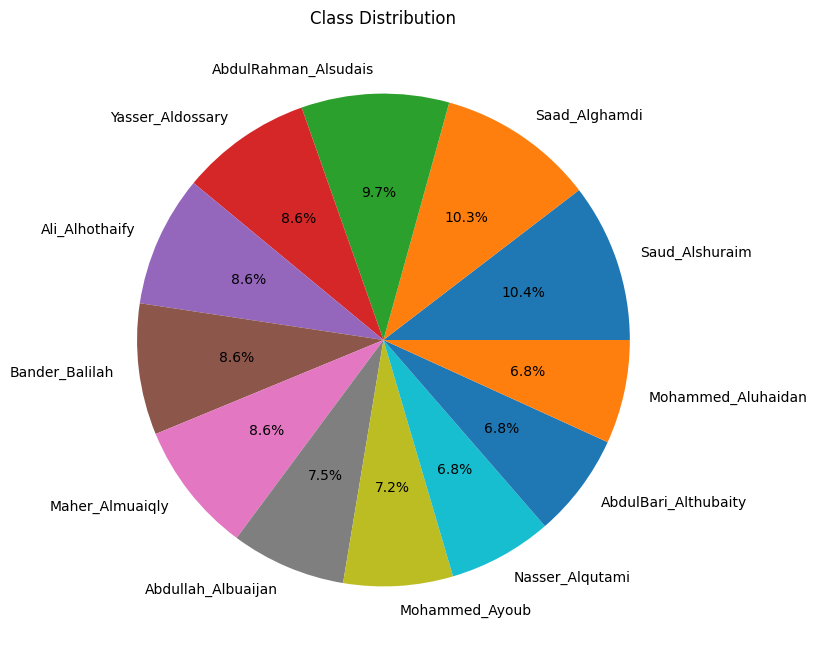

In [5]:
plt.figure(figsize=(8,8))
plt.pie(df['Class'].value_counts(),labels=df['Class'].value_counts().index,autopct='%1.1f%%')
plt.title("Class Distribution")
plt.show()

## ***DATA SPLIT***

In [6]:
encoder=LabelEncoder()
df['Class']=encoder.fit_transform(df['Class'])


train=df.sample(frac=0.7,random_state=7) #70 percent 
test=df.drop(train.index) # other 30 percent

val=test.sample(frac=0.5,random_state=7) # 15 percent 
test=test.drop(val.index) # drop val data
print(train.shape,test.shape,val.shape)


(4681, 2) (1003, 2) (1003, 2)


## ***Define Custom Class***

In [7]:
class CustomAudioDataset(Dataset):
    def __init__(self, dataframe, device='cuda'):
        self.dataframe = dataframe
        self.device = device
        self.labels = torch.tensor(dataframe['Class'].values, dtype=torch.long).to(device)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        file_path = self.dataframe.iloc[idx]['FilePath']
        spectrogram = self.get_spectrogram(file_path)
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0).to(self.device)  # (1, H, W)
        label = self.labels[idx]
        return spectrogram, label

    def get_spectrogram(self, file_path):
        sr = 22050
        duration = 5
        img_height = 128
        img_width = 256

        signal, _ = librosa.load(file_path, sr=sr, duration=duration)
        spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        spec_db = librosa.power_to_db(spec, ref=np.max)
        spec_resized = resize(spec_db, (img_height, img_width), anti_aliasing=True)
        return spec_resized

In [8]:
train_dataset=CustomAudioDataset(dataframe=train)
val_dataset=CustomAudioDataset(dataframe=val)
test_dataset=CustomAudioDataset(dataframe=test)

In [9]:
LR=1e-4
BATCH_SIZE=16
EPOCHS=15

In [10]:
train_loader=DataLoader(train_dataset,BATCH_SIZE,shuffle=True)
test_loader=DataLoader(test_dataset,BATCH_SIZE,shuffle=True)
val_loader=DataLoader(val_dataset,BATCH_SIZE,shuffle=True)

# ***Define Model***

In [11]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1=nn.Conv2d(1,16,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(16,32,kernel_size=3,padding=1)
        self.conv3=nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.pooling=nn.MaxPool2d(2,2)
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout(p=0.5)
        self.flatten=nn.Flatten()
        self.linear1=nn.Linear((64*16*32),4096)
        self.linear2=nn.Linear(4096,1024)
        self.linear3=nn.Linear(1024,512)
        self.output=nn.Linear(512,len(df['Class'].unique()))
    def forward(self,x):
        x=self.conv1(x)
        x=self.pooling(x)
        x=self.relu(x)
        x=self.conv2(x)
        x=self.pooling(x)
        x=self.relu(x)
        x=self.conv3(x)
        x=self.pooling(x)
        x=self.relu(x)

        x=x.view(x.size(0),-1)
        x=self.flatten(x)
        x=self.linear1(x)
        x=self.dropout(x)
        x=self.linear2(x)
        x=self.dropout(x)
        x=self.linear3(x)
        x=self.dropout(x)

        x=self.output(x)

        return x
        
    

In [12]:
model=Model().to(device)

# ***Summary of Created Model***

In [13]:
from torchsummary import summary
summary(model,(1,128,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
              ReLU-3          [-1, 16, 64, 128]               0
            Conv2d-4          [-1, 32, 64, 128]           4,640
         MaxPool2d-5           [-1, 32, 32, 64]               0
              ReLU-6           [-1, 32, 32, 64]               0
            Conv2d-7           [-1, 64, 32, 64]          18,496
         MaxPool2d-8           [-1, 64, 16, 32]               0
              ReLU-9           [-1, 64, 16, 32]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                 [-1, 4096]     134,221,824
          Dropout-12                 [-1, 4096]               0
           Linear-13                 [-1, 1024]       4,195,328
          Dropout-14                 [-

# ***Define loss & optimizer***

In [14]:
criterion=nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=LR)

# ***Training***

In [15]:
total_loss_train_plot=[]
total_loss_val_plot=[]

total_acc_train_plot=[]
total_acc_val_plot=[]

import time

st_time=time.time()

for epoch in range(EPOCHS):
    total_acc_train=0
    total_acc_val=0
    total_loss_val=0
    total_loss_train=0
    for inputs,labels in train_loader:
        outputs=model(inputs)
        loss=criterion(outputs,labels)
        total_loss_train+=loss.item()

        loss.backward()
        acc=(torch.argmax(outputs,dim=1)==labels).sum().item()
        total_acc_train+=acc
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for inputs,labels in val_loader:
            outputs=model(inputs)
            loss=criterion(outputs,labels)
            total_loss_val+=loss.item()
            acc=(torch.argmax(outputs,dim=1)==labels).sum().item()
            total_acc_val+=acc
        
    total_loss_train_plot.append(round(total_loss_train/len(train_dataset),4))
    total_loss_val_plot.append(round(total_loss_val/len(val_dataset),4))
    total_acc_train_plot.append(round(total_acc_train/len(train_dataset),4))
    total_acc_val_plot.append(round(total_acc_val/len(val_dataset),4))

    
    print(f"Epochs {epoch+1} Training loss {round(total_loss_train/len(train_dataset),4)} Training Accuracy{round(total_acc_train/len(train_dataset),4)}")
    
    print(f"Epochs {epoch+1} Validation loss {round(total_loss_val/len(val_dataset),4)} Validation Accuracy{round(total_acc_val/len(val_dataset),4)}")
        
    print('*'*80)

print("Traning time",round(time.time()-st_time,4))

Epochs 1 Training loss 0.1394 Training Accuracy0.4777
Epochs 1 Validation loss 0.0372 Validation Accuracy0.8156
********************************************************************************
Epochs 2 Training loss 0.0223 Training Accuracy0.8883
Epochs 2 Validation loss 0.0172 Validation Accuracy0.9013
********************************************************************************
Epochs 3 Training loss 0.0097 Training Accuracy0.9485
Epochs 3 Validation loss 0.0104 Validation Accuracy0.9442
********************************************************************************
Epochs 4 Training loss 0.006 Training Accuracy0.968
Epochs 4 Validation loss 0.0075 Validation Accuracy0.9521
********************************************************************************
Epochs 5 Training loss 0.0046 Training Accuracy0.9789
Epochs 5 Validation loss 0.0111 Validation Accuracy0.9571
********************************************************************************
Epochs 6 Training loss 0.0029 Trainin

# ***Test Dataset Accuracy***

In [20]:
with torch.no_grad():
    total_loss_test=0
    total_acc_test=0
    for inputs,labels in test_loader:
        output=model(inputs)
        loss=criterion(output,labels).item()
        total_loss_test+=loss
        acc=acc=(torch.argmax(output,axis=1)==labels).sum().item()
        total_acc_test+=acc

print(f"Total Accuracy score is {round(total_acc_test/len(test_dataset)*100,4)}")

Total Accuracy score is 96.4108


# ***Train Dataset Accuracy Separately***

In [22]:
with torch.no_grad():
    total_loss_train=0
    total_acc_train=0
    for inputs,labels in train_loader:
        output=model(inputs)
        loss=criterion(output,labels).item()
        total_loss_train+=loss
        acc=acc=(torch.argmax(output,axis=1)==labels).sum().item()
        total_acc_train+=acc

print(f"Total Accuracy score is {round(total_acc_train/len(train_dataset)*100,4)}")

Total Accuracy score is 99.6582


# ***Visualization of Loss & Accuracy***

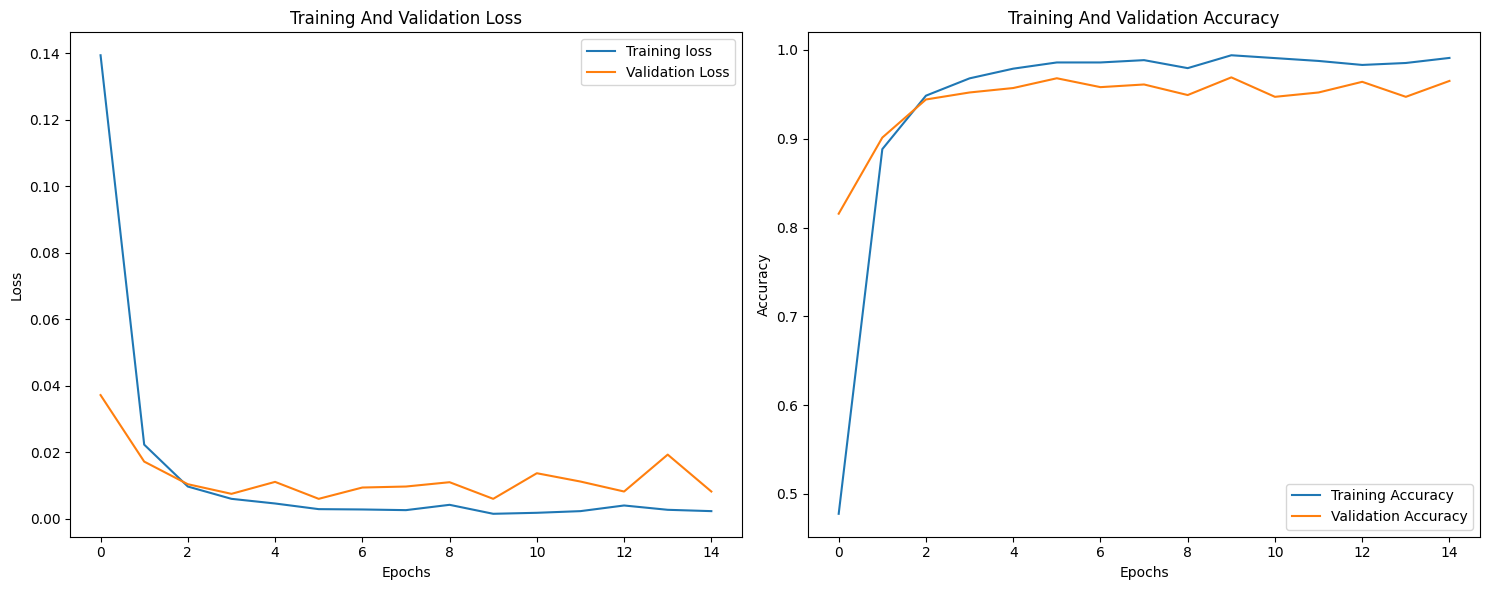

In [23]:
fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(15,6))

axs[0].plot(total_loss_train_plot,label='Training loss')
axs[0].plot(total_loss_val_plot,label='Validation Loss')
axs[0].set_title('Training And Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(total_acc_train_plot,label='Training Accuracy')
axs[1].plot(total_acc_val_plot,label='Validation Accuracy')
axs[1].set_title('Training And Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()